In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import resample
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.utils import resample

import matplotlib.pyplot as plt
import seaborn as sns

## Data and code

In [145]:
features_no_speech=pd.read_csv('/home/gbarchi/Documentos/Trust/OCEAN-TRUST/data/features/new_partitions-egemaps_silero_no_speech.csv')
features_speech=pd.read_csv('/home/gbarchi/Documentos/Trust/OCEAN-TRUST/data/features/new_partitions-egemaps_silero_speech.csv')
labels=pd.read_csv('/home/gbarchi/Documentos/Trust/OCEAN-TRUST/data/labels/new_partitions-labels.csv')

In [146]:
list_music='/home/gbarchi/Documentos/Trust/OCEAN-TRUST/data/lists/silero_th_0.5_no_speech_music.txt'
list_no_music='/home/gbarchi/Documentos/Trust/OCEAN-TRUST/data/lists/silero_th_0.5_no_speech_no_music.txt'

In [174]:
def concat_df(DF_features,DF_labels):

    # Concat features and label dataframes

    DF=pd.merge(DF_features,DF_labels,left_on='Name',right_on='audio_tag').drop(columns='audio_tag')

    if 'Part' in DF.columns:
        DF=DF.drop(columns='Part')

    return DF

def filter_df(DF,filter_list):
    
    with open (filter_list,'r') as file:
        list=file.read().splitlines()
    
    filtered_df=DF[DF['Name'].isin(list)] 

    return filtered_df

def format_data(df_features, df_labels, filter_list):
    
    df=concat_df(df_features,df_labels)
    df=filter_df(df,filter_list)

    return df 

def train_model(df_train,feature_tags,label_tags,seed,rf_n_jobs=None):  
    
    X_train,Y_train=split_X_Y(df_train,feature_tags,label_tags)
    
    RF_reg=RandomForestRegressor(random_state=seed,n_jobs=rf_n_jobs) 
    
    RF_reg.fit(X_train.values,Y_train.values)
 
    return RF_reg

def split_X_Y(df,feature_tags,label_tags):
    
    df_X=df[feature_tags]
    df_Y=df[label_tags]

    return df_X, df_Y
  
def predict(RF_reg, val,feature_tags,label_tags):
    
    X_val, Y_val= split_X_Y(val,feature_tags,label_tags)

    predictions=RF_reg.predict(X_val.values)

    r2=r2_score(Y_val, predictions)    

    MAE=mean_absolute_error(Y_val, predictions)
    MSE=mean_squared_error(Y_val, predictions)
    RMSE=np.sqrt(mean_squared_error(Y_val, predictions))

    return r2,MAE,MSE,RMSE,Y_val,predictions

def make_folds(df,n_folds=5):
    
    df_final=pd.DataFrame()
    folds=[]
   
    for i in df.index:
        df.loc[i,'basename']=df.loc[i,'Name'].split('.')[0]
    
    folds_len=int(len(df.basename.unique())/5)
    unique=df.basename.unique()
    
    for i in range(n_folds):
        fold=np.random.choice(unique,size=folds_len,replace=False)
        folds.append(fold)
        unique =[j for j in unique if not j in fold]
        df_=df[df['basename'].isin(fold)]
        df_.loc[:,'fold']=int(i+1)
        df_final=pd.concat([df_final,df_])
    if not len(unique)==0:
        df_rest=df[df['basename'].isin(unique)]
        df_rest.loc[:,'fold']=5
        df_final=pd.concat([df_final,df_rest])
    return df_final

def cross_val(df,feature_tags,label_tags,n_folds=5):
    feature_importance=[]
    metrics_list=[]
    
    df_final=make_folds(df,n_folds)

    for fold in range(n_folds):
        df_val=df_final[df_final['fold']==fold+1]
        df_train=df_final[~df_final['basename'].isin(df_val.basename)]
        RF_reg= train_model (df_train,feature_tags,label_tags,42)
                
        r2_all,MAE_all,MSE_all,RMSE_all,y_val,predictions= predict(RF_reg,df_val,feature_tags,label_tags)
        metrics=[r2_all,np.sqrt(r2_all),MAE_all,MSE_all,RMSE_all,fold]
        metrics_list.append(metrics)

        feature_importance.append(RF_reg.feature_importances_)

    metrics_list=np.transpose(metrics_list)
    df_fold=pd.DataFrame({'r2':metrics_list[0],'r':metrics_list[1],'MAE':metrics_list[2],'MSE':metrics_list[3],'RMSE':metrics_list[4],'fold':metrics_list[5]})
    return df_fold,feature_importance,y_val,predictions

def create_importance_df(importance_data,data_type):
    
    df_importance=pd.DataFrame()
    for i in range(len(importance_data)):
        percentil_95=np.percentile(importance_data[i],95)
        values=importance_data[i][importance_data[i]>percentil_95]
        values_indexes=np.asarray(importance_data[i]>percentil_95).nonzero()
        importance_df=pd.DataFrame({'features':feature_tags[values_indexes],'value':values,'fold':i,'data_type':data_type})
        df_importance=pd.concat([df_importance,importance_df])
    return df_importance

In [148]:
label_tags=['extraversion', 'neuroticism','agreeableness', 'conscientiousness', 'openness']
feature_tags=features_no_speech.columns[~features_no_speech.columns.isin(['Name','Part'])]

# No speech + music

In [149]:
import warnings

In [176]:
warnings.filterwarnings('ignore')
df_ns_m=format_data(features_no_speech,labels,list_music)
df_ns_m=df_ns_m.reset_index().drop(columns='index')
scores_ns_m,importance_ns_m,y_val_ns_m,predictions_ns_m=cross_val(df_ns_m,feature_tags,label_tags,5)

In [177]:
scores_ns_m

,r2,r,MAE,MSE,RMSE,fold
0,0.011129,0.105496,0.111986,0.018299,0.135273,0.0
1,0.094290,0.307067,0.106658,0.017886,0.133738,1.0
2,0.061323,0.247635,0.109084,0.018172,0.134805,2.0
3,0.098517,0.313874,0.100529,0.016424,0.128154,3.0
4,0.003191,0.056493,0.092451,0.013435,0.115907,4.0


In [152]:
np.mean(scores_ns_m.r2.values)

0.01878424371328242

Prediction error

In [236]:
error_ns_m=y_val_ns_m-predictions_ns_m
for k in error_ns_m.index:
    error_ns_m.loc[k,'Name']=df_ns_m.loc[k,'Name']
    error_ns_m.loc[k,'Mean']=np.mean(error_ns_m.loc[k][:5].values)

In [237]:
error_ns_m

,extraversion,neuroticism,agreeableness,conscientiousness,openness,Name,Mean
0,0.025140,-0.104792,0.027363,-0.122427,0.010667,XB81sertsYU.004.wav,-0.032810
1,-0.178318,-0.047500,-0.062857,-0.017379,-0.062333,X1EjfXX3NTk.002.wav,-0.073677
13,-0.298411,-0.209896,-0.080659,-0.248544,-0.300667,RQeoo3idUJc.005.wav,-0.227635
14,-0.022710,0.145312,0.064396,0.052330,-0.051333,k4eeYoHtnnI.002.wav,0.037599
15,-0.086262,-0.195417,-0.066593,0.047864,-0.123556,cx8IycWgMVs.000.wav,-0.084793
...,...,...,...,...,...,...,...
280,-0.238972,-0.132292,-0.113626,0.041165,-0.021778,sPMNhG1Sehc.000.wav,-0.093101
284,0.063271,0.059583,-0.063956,-0.016408,0.085778,TeNC9wOhlXM.001.wav,0.025654
285,-0.117103,0.009062,-0.085824,-0.124175,-0.036778,KNx7_ajRwDI.002.wav,-0.070963
297,-0.133645,-0.091667,-0.301099,-0.083107,-0.015667,hl70w5drc_4.005.wav,-0.125037


Samples with -0.01< Mean error < 0.01

In [248]:
best_ns_m=error_ns_m[(error_ns_m['Mean']<0.01)&(error_ns_m['Mean']>-0.01)]

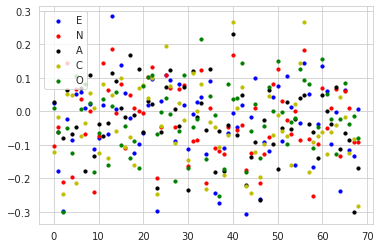

In [203]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(np.arange(0,error_ns_m.shape[0]),error_ns_m.extraversion.values, s=10, c='b', marker="o", label='E')
ax1.scatter(np.arange(0,error_ns_m.shape[0]),error_ns_m.neuroticism.values, s=10, c='r', marker="o", label='N')
ax1.scatter(np.arange(0,error_ns_m.shape[0]),error_ns_m.agreeableness.values, s=10, c='k', marker="o", label='A')
ax1.scatter(np.arange(0,error_ns_m.shape[0]),error_ns_m.conscientiousness.values, s=10, c='y', marker="o", label='C')
ax1.scatter(np.arange(0,error_ns_m.shape[0]),error_ns_m.openness.values, s=10, c='g', marker="o", label='O')
plt.legend(loc='upper left')
plt.show()

## no speech + no music

In [240]:
df_ns_nm=format_data(features_no_speech,labels,list_no_music)
df_ns_nm=df_ns_nm.reset_index().drop(columns='index')
scores_ns_nm,importance_ns_nm,y_val_ns_nm,predictions_ns_nm=cross_val(df_ns_nm,feature_tags,label_tags,5)

In [241]:
scores_ns_nm

,r2,r,MAE,MSE,RMSE,fold
0,0.125304,0.353984,0.111725,0.019274,0.138830,0.0
1,0.004020,0.063400,0.113090,0.020605,0.143546,1.0
2,0.049356,0.222163,0.109368,0.018424,0.135736,2.0
3,0.024052,0.155087,0.116637,0.021189,0.145565,3.0
4,0.128245,0.358114,0.117466,0.021217,0.145659,4.0


In [242]:
np.mean(scores_ns_nm.r2.values)

0.06619554772435092

In [243]:
scores_ns_nm

,r2,r,MAE,MSE,RMSE,fold
0,0.125304,0.353984,0.111725,0.019274,0.138830,0.0
1,0.004020,0.063400,0.113090,0.020605,0.143546,1.0
2,0.049356,0.222163,0.109368,0.018424,0.135736,2.0
3,0.024052,0.155087,0.116637,0.021189,0.145565,3.0
4,0.128245,0.358114,0.117466,0.021217,0.145659,4.0


Prediction Error

In [244]:
error_ns_nm=y_val_ns_nm-predictions_ns_nm
for k in error_ns_nm.index:
    error_ns_nm.loc[k,'Name']=df_ns_nm.loc[k,'Name']
    error_ns_nm.loc[k,'Mean']=np.mean(error_ns_nm.loc[k][:5].values)

Samples with -0.01< Mean error < 0.01

In [247]:
best_ns_nm=error_ns_nm[(error_ns_nm['Mean']<0.01)&(error_ns_nm['Mean']>-0.01)]

## Speech vs No-Speech check

In [160]:
scores_ns_m.loc[:,'type']='music'
scores_ns_m.loc[:,'feature']='non-speech'
scores_ns_nm.loc[:,'type']='no_music'
scores_ns_nm.loc[:,'feature']='non-speech'
df=pd.concat([scores_ns_m,scores_ns_nm])

In [161]:
df

,r2,r,MAE,MSE,RMSE,fold,type,feature
0,-0.090907,NaN,0.103191,0.016723,0.129319,0.0,music,non-speech
1,0.028995,0.170280,0.104607,0.016887,0.129949,1.0,music,non-speech
2,-0.133054,NaN,0.112383,0.019461,0.139503,2.0,music,non-speech
3,0.190814,0.436823,0.101933,0.017111,0.130810,3.0,music,non-speech
4,0.098073,0.313165,0.104009,0.016685,0.129170,4.0,music,non-speech
0,0.061747,0.248489,0.119235,0.022563,0.150210,0.0,no_music,non-speech
1,0.050508,0.224741,0.112002,0.020166,0.142006,1.0,no_music,non-speech
2,0.110537,0.332471,0.113988,0.020423,0.142907,2.0,no_music,non-speech
3,0.030459,0.174524,0.117673,0.020881,0.144502,3.0,no_music,non-speech
4,0.105749,0.325191,0.100647,0.016495,0.128435,4.0,no_music,non-speech


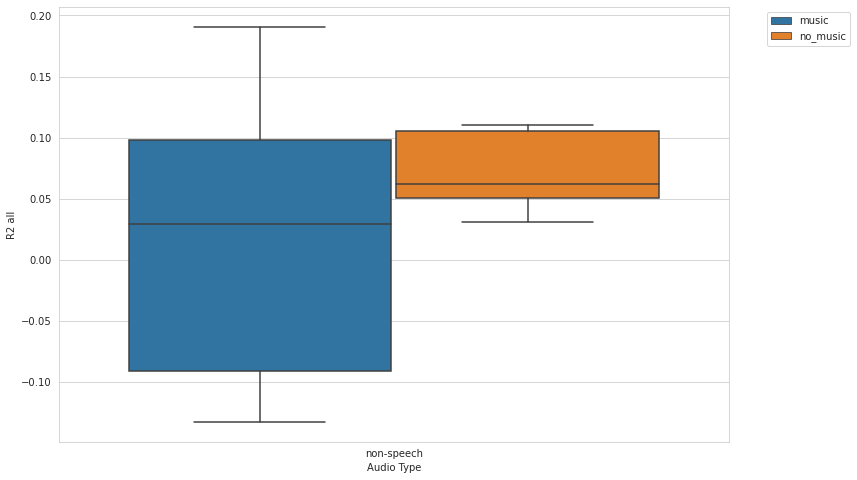

In [162]:
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
ax=sns.boxplot(data=df,x='feature',y='r2',hue='type')
ax.set(xlabel='Audio Type', ylabel='R2 all')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

# Importance

Importance values greater than 95 percentile for every fold in each condition

In [163]:
df_importance_ns_m=create_importance_df(importance_ns_m,'ns_m')
df_importance_ns_nm=create_importance_df(importance_ns_nm,'ns_nm')

No speech + Music

In [167]:
df_importance_ns_m.sort_values(by='value',ascending=False)

,features,value,fold,data_type
4,StddevUnvoicedSegmentLength,0.134284,0,ns_m
4,StddevUnvoicedSegmentLength,0.113050,4,ns_m
4,StddevUnvoicedSegmentLength,0.102947,2,ns_m
4,StddevUnvoicedSegmentLength,0.098402,1,ns_m
4,StddevUnvoicedSegmentLength,0.083629,3,ns_m
2,mfcc2_sma3_stddevNorm,0.036344,3,ns_m
0,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,0.031427,2,ns_m
1,loudness_sma3_stddevRisingSlope,0.031138,1,ns_m
1,mfcc1_sma3_amean,0.030272,4,ns_m
0,loudness_sma3_meanRisingSlope,0.030020,4,ns_m


In [171]:
df_importance_ns_m.sort_values(by='value',ascending=False).features.unique()

array(['StddevUnvoicedSegmentLength', 'mfcc2_sma3_stddevNorm',
       'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
       'loudness_sma3_stddevRisingSlope', 'mfcc1_sma3_amean',
       'loudness_sma3_meanRisingSlope', 'F1bandwidth_sma3nz_stddevNorm',
       'loudnessPeaksPerSec', 'spectralFlux_sma3_stddevNorm',
       'mfcc1V_sma3nz_stddevNorm', 'mfcc2_sma3_amean',
       'HNRdBACF_sma3nz_amean', 'F1frequency_sma3nz_amean'], dtype=object)

No Speech + No music

In [166]:
df_importance_ns_nm.sort_values(by='value',ascending=False)

,features,value,fold,data_type
3,MeanUnvoicedSegmentLength,0.061570,1,ns_nm
3,MeanUnvoicedSegmentLength,0.056310,0,ns_nm
2,spectralFlux_sma3_amean,0.054241,3,ns_nm
0,loudness_sma3_amean,0.053834,3,ns_nm
0,loudness_sma3_amean,0.053195,4,ns_nm
3,MeanUnvoicedSegmentLength,0.052385,4,ns_nm
4,MeanUnvoicedSegmentLength,0.051425,2,ns_nm
0,loudness_sma3_pctlrange0-2,0.050535,1,ns_nm
4,MeanUnvoicedSegmentLength,0.048131,3,ns_nm
4,equivalentSoundLevel_dBp,0.043970,0,ns_nm


In [172]:
df_importance_ns_nm.sort_values(by='value',ascending=False).features.unique()

array(['MeanUnvoicedSegmentLength', 'spectralFlux_sma3_amean',
       'loudness_sma3_amean', 'loudness_sma3_pctlrange0-2',
       'equivalentSoundLevel_dBp', 'mfcc4_sma3_amean',
       'loudness_sma3_percentile80.0', 'spectralFluxUV_sma3nz_amean',
       'loudness_sma3_stddevRisingSlope', 'mfcc2_sma3_stddevNorm'],
      dtype=object)